# Explanatory Data Analysis: Experiment 00a
Identity Distribution, Image Quality

In [ ]:
import cv2
import torch
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from concurrent.futures import ProcessPoolExecutor

from jaguar.datasets import get_data

In [ ]:
BASE_CONFIG = {
    "random_seed": 42,
    "data_dir": Path("../../data"),
    "validation_split_size": 0.2,
    "cache_dir": Path("../../cache"),
    "embeddings_dir": Path("../../embeddings")
}
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(BASE_CONFIG["random_seed"])
pd.set_option('display.width', 1000)
np.random.seed(BASE_CONFIG["random_seed"])

In [ ]:
train_data, val_data, test_data, num_classes, label_encoder = get_data(
    data_path=BASE_CONFIG["data_dir"], 
    validation_split_size=BASE_CONFIG["validation_split_size"], 
    seed=BASE_CONFIG["random_seed"]
)
display(train_data.head())

,filename,ground_truth,label_encoded
1372,../../../data/train/train/train_1373.png,Ousado,20
775,../../../data/train/train/train_0776.png,Kwang,15
1094,../../../data/train/train/train_1095.png,Marcela,18
1784,../../../data/train/train/train_1785.png,Ti,29
112,../../../data/train/train/train_0113.png,Benita,6


## Identity Distribution

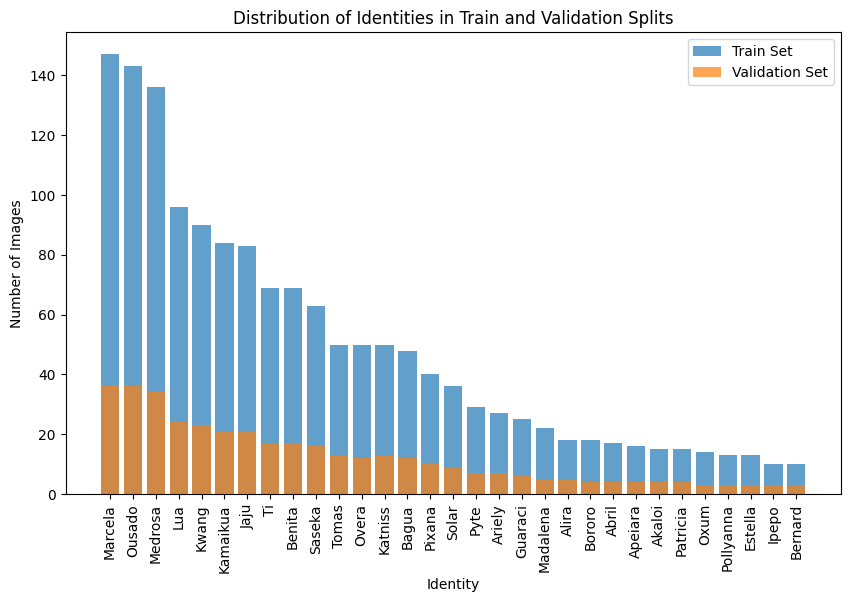

In [ ]:
plt.figure(figsize=(10, 6))
train_identity_counts = pd.Series(train_data['ground_truth']).value_counts()
plt.bar(train_identity_counts.index, train_identity_counts.values, alpha=0.7)
val_identity_counts = pd.Series(val_data['ground_truth']).value_counts()
plt.bar(val_identity_counts.index, val_identity_counts.values, alpha=0.7)
plt.legend(['Train Set', 'Validation Set'])
plt.xlabel('Identity')
plt.ylabel('Number of Images')
plt.title('Distribution of Identities in Train and Validation Splits')
plt.xticks(rotation=90)
plt.show()

## Image Quality

In [ ]:
def get_metrics_rgba(img_path):
    img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
    if img is None: 
        return {"Sharpness": 0, "Brightness": 0, "Contrast": 0, "Area_Ratio": 0}
    
    if img.shape[2] == 4:
        mask = img[:, :, 3] > 0
    else:
        mask = np.ones((img.shape[0], img.shape[1]), dtype=bool)
    
    if not np.any(mask):
        return {"Sharpness": 0, "Brightness": 0, "Contrast": 0, "Area_Ratio": 0}

    gray = cv2.cvtColor(img[:, :, :3], cv2.COLOR_BGR2GRAY)
    jaguar_pixels = gray[mask]
    
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    
    return {
        "Sharpness": laplacian[mask].var(),
        "Brightness": np.mean(jaguar_pixels),
        "Contrast": np.std(jaguar_pixels),
        "Jaguar/Background Ratio": jaguar_pixels.size / gray.size
    }

paths = train_data['filename'].values

with ProcessPoolExecutor() as executor:
    results = list(tqdm(executor.map(get_metrics_rgba, paths), total=len(paths)))

image_quality_df = pd.DataFrame(results)
image_quality_df['Ground_Truth'] = train_data['ground_truth'].values
image_quality_df['Filename'] = paths

display(image_quality_df.head())

  0%|          | 0/1516 [00:00<?, ?it/s]

,Sharpness,Brightness,Contrast,Jaguar/Background Ratio,Ground_Truth,Filename
0,59.099709,111.303329,53.649127,0.462238,Ousado,../../../data/train/train/train_1373.png
1,21.670008,81.581636,61.066883,0.673663,Kwang,../../../data/train/train/train_0776.png
2,65.063075,120.908217,71.745279,0.473480,Marcela,../../../data/train/train/train_1095.png
3,21.860707,141.460859,56.362215,0.262491,Ti,../../../data/train/train/train_1785.png
4,591.450684,68.876487,42.610068,0.512899,Benita,../../../data/train/train/train_0113.png


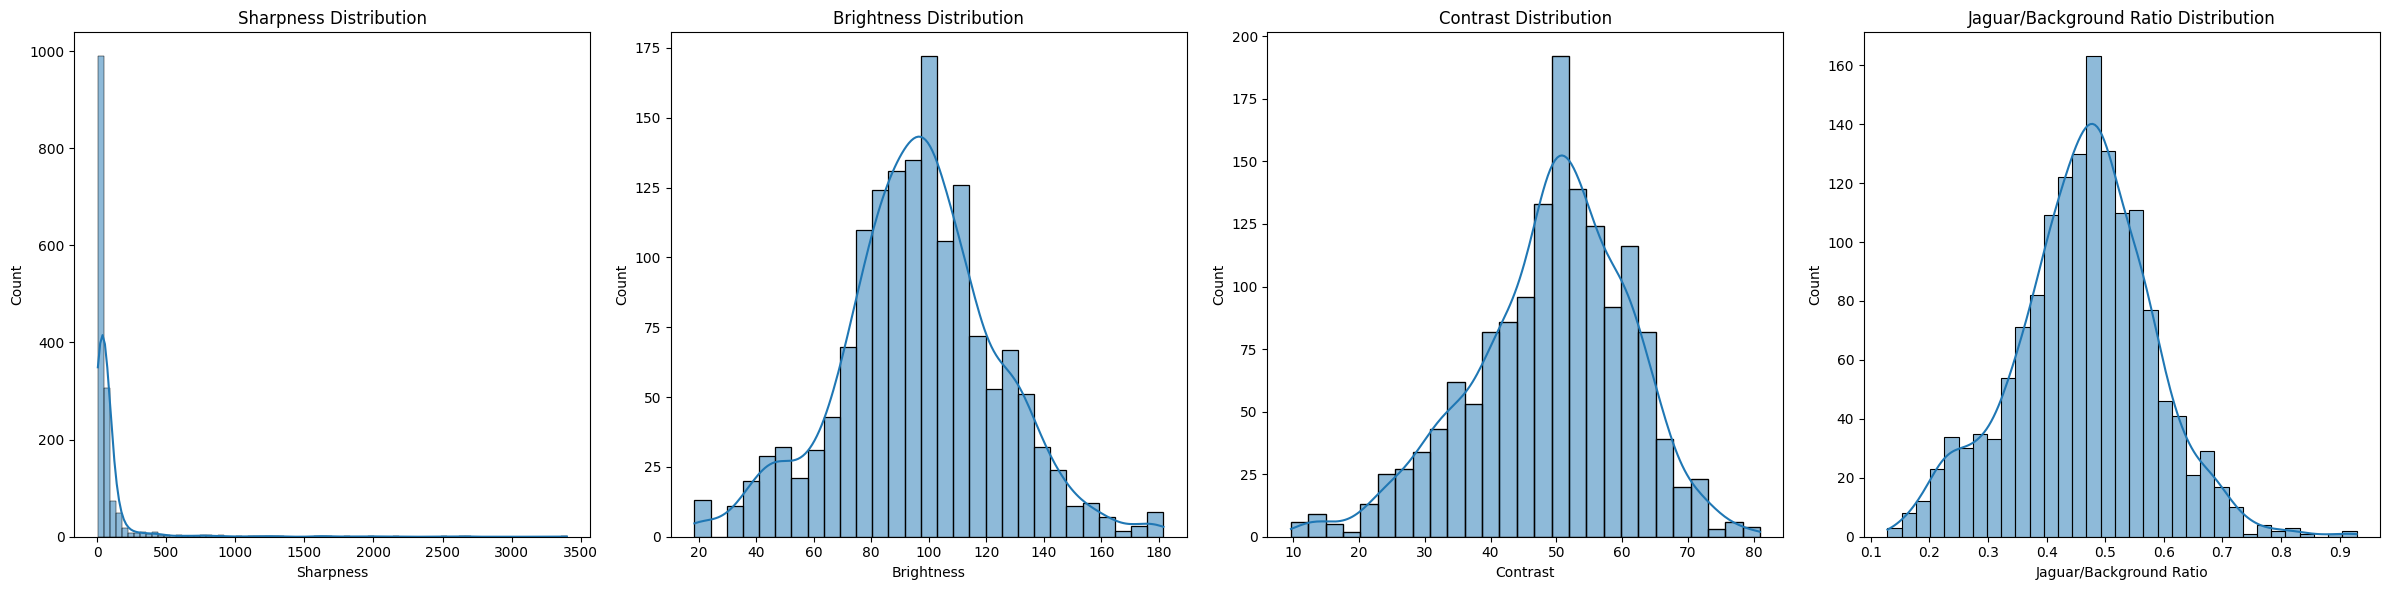

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
sns.histplot(image_quality_df, x='Sharpness', ax=axes[0], kde=True)
axes[0].set_title('Sharpness Distribution')
sns.histplot(image_quality_df, x='Brightness', ax=axes[1], kde=True)
axes[1].set_title('Brightness Distribution')
sns.histplot(image_quality_df, x='Contrast', ax=axes[2], kde=True)
axes[2].set_title('Contrast Distribution')
sns.histplot(image_quality_df, x='Jaguar/Background Ratio', ax=axes[3], kde=True)
axes[3].set_title('Jaguar/Background Ratio Distribution')
plt.tight_layout()